## Benchmarking Circuit Depth for PEC
***

# Imports

In [317]:
import functools
import os
import time
from typing import List
import matplotlib.pyplot as plt
import cirq
import networkx as nx
import numpy as np
import qiskit
from mitiq import benchmarks, pec

# Set up hardware
We need chain-like connectivity for mirror circuits. Physical qubit structure is used for initial_layout argument in the executor.

In [318]:
def get_phys_qubits(n_qubits):
    # Physical qubits of ibmq-kolkata with a chain-like connectivity.
    ibm_lima_ordering = [0, 1, 3, 4, 2]
    ibm_kolkata_ordering = [
        0,
        1,
        4,
        7,
        10,
        12,
        15,
        18,
        21,
        23,
        24,
        25,
        22,
        19,
        16,
        14,
        11,
        8,
        5,
        3,
        2,
    ]

    if n_qubits <= 5:
        # Assume ibmq-lima device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_lima_ordering[: n_qubits]
    elif n_qubits <= len(ibm_kolkata_ordering):
        # Assume ibmq-kolkata device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_kolkata_ordering[: n_qubits]
    else:
        raise ValueError(f"Number of qubits {n_qubits} too large.")
    
    return physical_ibm_qubits

# Make connectivity graph for mirror circuits

In [319]:
def get_computer(n_qubits):
    # Make connectivity graph 
    computer = nx.Graph()

    qubits = [j for j in range(n_qubits)]

    # Split qubits into 2-qubit pairs (assuming a chain connectivity).
    rb_pattern = [[qa, qb] for qa, qb in zip(qubits[0:-1:2], qubits[1::2])]
    if n_qubits % 2 == 1:
        # For an odd number of qubits, append final individual qubit to the RB pattern.
        rb_pattern.append([qubits[-1]])
    # print("Qubit indeces:", qubits)
    # print("RB pattern:", rb_pattern)

    # Assume chain-like connectivity
    computer.add_edges_from([(qa, qb) for qa, qb in zip(qubits[:-1], qubits[1:])])

    # Add reversed edges to computer graph.
    # This is important to represent CNOT gates with target and control reversed.
    computer = nx.to_directed(computer)
    return computer

# Create circuit for testing
Specify:
1. Benchmarking circuit type
2. Number of qubits
3. Depth
4. Seed

In [320]:
def get_circuit(circuit_type:str, n_qubits:int, depth: int, seed: int) -> tuple[qiskit.QuantumCircuit, str]:
    """Create circuit."""
    
    if circuit_type == "rb":
        circuit = benchmarks.generate_rb_circuits(
            n_qubits=2, 
            num_cliffords=depth, 
            seed=seed, 
            return_type="qiskit"
            )[0]
        return circuit, "00"

    elif circuit_type == "mirror":
        # Make connectivity graph 
        computer = get_computer(n_qubits)
        circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
                nlayers=depth,
                two_qubit_gate_prob=1.0,
                connectivity_graph=computer,
                two_qubit_gate_name="CNOT",
                seed=seed,
                return_type="qiskit",
            )
        # Reversed because Qiskit is wrong endian.
        return circuit, "".join(map(str, correct_bitstring[::-1]))
    
    else:
        print("what")
        return
    
# We can add in more types later

In [321]:
circuit, cb = get_circuit("mirror", 2, 3, 1)
circuit.draw()

┌───┐   ┌──────┐┌───┐     ┌───┐     ┌───┐     ┌───┐     ┌───┐     ┌───┐»
q_0: ───┤ Y ├───┤ √Xdg ├┤ X ├──■──┤ X ├──■──┤ Z ├──■──┤ X ├──■──┤ Y ├──■──┤ Y ├»
     ┌──┴───┴──┐├──────┤├───┤┌─┴─┐├───┤┌─┴─┐├───┤┌─┴─┐├───┤┌─┴─┐├───┤┌─┴─┐├───┤»
q_1: ┤ Ry(π/2) ├┤ √Xdg ├┤ X ├┤ X ├┤ X ├┤ X ├┤ Y ├┤ X ├┤ I ├┤ X ├┤ Z ├┤ X ├┤ X ├»
     └─────────┘└──────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«          ┌───┐┌────┐   ┌───┐    
«q_0: ──■──┤ Y ├┤ √X ├───┤ Y ├────
«     ┌─┴─┐├───┤├────┤┌──┴───┴───┐
«q_1: ┤ X ├┤ I ├┤ √X ├┤ Ry(-π/2) ├
«     └───┘└───┘└────┘└──────────┘

# General Parameters

1. Backends
2. Seed
3. Verbosity of output

In [322]:
# Simulators (Add in real one later)
from qiskit.providers.fake_provider import GenericBackendV2
noisy_backend = GenericBackendV2(num_qubits=6)

import qiskit_aer
ideal_backend = qiskit_aer.AerSimulator()

# Random seed for circuit generation.
seed: int = 1

# Display verbose output.
verbose: bool = True
# Give queue updates every this many seconds when running on hardware device.
verbose_update_time: int = 30

# Save data (cnot_counts, oneq_counts, true_values, noisy_values, zne_values, etc.).
save_data: bool = True

Count the number of CNOT gates in the circuit.

In [323]:
def get_num_cnot_count(circuit: qiskit.QuantumCircuit) -> int:
    """Determine number of cnot gates in a given `Circuit` object."""
    return circuit.count_ops().get("cx")

def get_avg_cnot_count(circuits: list[qiskit.QuantumCircuit]) -> float:
    """Determine average number of cnot gates present in list of `QuantumCircuit` objects."""
    return np.average([c.count_ops().get("cx") for c in circuits])

def get_oneq_count(circuit: qiskit.QuantumCircuit) -> int:
    return len(circuit) - get_num_cnot_count(circuit)

# Create executor

In [324]:
def execute(
    circuits: qiskit.QuantumCircuit | list[qiskit.QuantumCircuit],
    backend,
    shots: int,
    correct_bitstring: str,
    verbose: bool = verbose,
    ) -> List[float]:
    """Executes the input circuit(s) and returns ⟨A⟩, where A = |correct_bitstring⟩⟨correct_bitstring| for each circuit."""

    if not isinstance(circuits, list):
        circuits = [circuits]
    if verbose:
        # Calculate average number of CNOT gates per circuit.
        print(f"Executing {len(circuits)} circuit(s) on {backend}.")
        print(f"Average cnot count in circuits: {get_avg_cnot_count(circuits)}")

    # Store all circuits to run in list to be returned.
    to_run: list[qiskit.QuantumCircuit] = []

    for circuit in circuits:
        circuit_to_run = circuit.copy()
        circuit_to_run.measure_all()
        to_run.append(
            qiskit.transpile(
                circuit_to_run,
                backend=backend,
                initial_layout= get_phys_qubits(circuit.num_qubits),
                optimization_level=0,  # Otherwise RB circuits are simplified to empty circuits.
            )
        )

    if verbose:
        # Calculate average number of CNOT gates per compiled circuit.
        print(f"Average cnot count in compiled circuits: {get_avg_cnot_count(to_run)}")

    # Run and get counts.
    job = backend.run(
        to_run,
        # Reset qubits to ground state after each sample.
        init_qubits=True,
        shots=shots,
    )
    # IBMQ uses online queue for processing jobs.
    # if verbose and not use_noisy_simulator:
    #     time.sleep(3)
    #     while not job.in_final_state():
    #         print(f"Queue position: {job.queue_position()}")
    #         time.sleep(verbose_update_time)
    #     print()

    print(f"Correct bitstring: {correct_bitstring}")
    if len(circuits) == 1:
        return [job.result().get_counts().get(correct_bitstring, 0.0) / shots]
    return [
        count.get(correct_bitstring, 0.0) / shots for count in job.result().get_counts()
    ]

# Introduce error

In [325]:
def get_cnot_error(edge: tuple[int, int] = None) -> float:
    cnot_error_prob = 0.01
    #cnot_error_prob = noisy_backend.properties().gate_error("cx", qubits=edge)
    print(f"cnot_error_prob for edge {edge}: {cnot_error_prob}")
    return cnot_error_prob

def get_cnot_representation(edge: tuple[int, int]) -> pec.OperationRepresentation:
    cnot_circuit = cirq.Circuit(
        cirq.CNOT(
            cirq.NamedQubit(f"q_{str(edge[0])}"),
            cirq.NamedQubit(f"q_{str(edge[1])}"),
        )
    )
    rep_exact_prob = 1 - np.sqrt(1 - get_cnot_error(edge))
    return pec.represent_operation_with_local_depolarizing_noise(
        cnot_circuit,
        noise_level=rep_exact_prob,
    )

def get_representations(computer: nx.Graph) -> list[pec.OperationRepresentation]:
    return [get_cnot_representation(edge) for edge in computer.edges]

# Run experiment
Specify:
1. Depth
2. Trials
3. Number of qubits (for computer)
4. Shots
5. Number of samples

In [326]:
def run_experiment(depth, trials, n_qubits, shots, num_samples, circuit_type):
    computer = get_computer(n_qubits)

    true_vals = []
    noisy_vals = []
    pec_vals = []
    cnots = []
    oneqs = []

    for trial in range(trials):
        # Local seed is calculated in this way to ensure that we don't get repeat values in loop.
        local_seed = int(10**6 * depth + 10**3 * seed + trial)

        circuit, correct_bitstring = get_circuit(circuit_type, n_qubits, depth, local_seed)

        (true_value,) = execute(
            circuit,
            ideal_backend,
            shots,
            correct_bitstring,
            verbose=verbose,
        )
        true_vals.append(true_value)

        (noisy_value,) = execute(
            circuit,
            noisy_backend,
            shots,
            correct_bitstring,
            verbose=verbose
        )
        noisy_vals.append(noisy_value)

        pec_executor = functools.partial(
            execute,
            backend=noisy_backend,
            shots=shots // num_samples,
            correct_bitstring=correct_bitstring,
            verbose=verbose,
        )

        pec_value = pec.execute_with_pec(
            circuit,
            pec_executor,
            representations=get_representations(computer),
            num_samples=num_samples,
            random_state=local_seed,
        )
        pec_vals.append(pec_value)

        cnots.append(get_num_cnot_count(circuit))
        oneqs.append(get_oneq_count(circuit))

    return true_vals, noisy_vals, pec_vals, cnots, oneqs

# Is PEC still useful?


In [327]:
def still_useful(true_value, noisy_values, pec_values) -> bool:
    pec_diffs=[]
    noisy_diffs=[]
    for trial_i in range(0, len(pec_values)):
        pec_diffs.append(np.abs(true_value - pec_values[trial_i]))
        noisy_diffs.append(np.abs(true_value - noisy_values[trial_i]))
    min_pec_diff = np.min(pec_diffs)
    min_noisy_diff = np.min(noisy_diffs)

    if min_pec_diff <= min_noisy_diff:
        return True
    elif min_pec_diff >= min_noisy_diff:
        return False

# Now let's run some stuff!

In [328]:
depths = np.arange(1,101)
trials = 3
n_qubits = 2
shots = 10000
num_samples = 100
circuit_type= "mirror"

In [ ]:
cnot_counts=[]
oneq_counts = []

true_values=[]
noisy_values = []
pec_values = []

avg_true_values=[]
avg_noisy_values = []
avg_pec_values = []

std_true_values = []
std_noisy_values = []
std_pec_values = []

still_useful_counter = 0

for depth_i in range(0,len(depths)):
    print("Status: On depth", depths[depth_i], end="\n\n")

    true_vals, noisy_vals, pec_vals, cnots, oneqs = run_experiment(depths[depth_i], trials, n_qubits, shots, num_samples, circuit_type)

    true_values.append(true_vals)
    noisy_values.append(noisy_vals)
    pec_values.append(pec_vals)

    avg_true_values.append(np.average(true_vals))
    avg_noisy_values.append(np.average(noisy_vals))
    avg_pec_values.append(np.average(pec_vals))

    std_true_values.append(np.std(true_vals, ddof=1))
    std_noisy_values.append(np.std(noisy_vals, ddof=1))
    std_pec_values.append(np.std(pec_vals, ddof=1))

    cnot_counts.append(cnots)
    oneq_counts.append(oneqs)

    if still_useful(avg_true_values[depth_i], noisy_vals, pec_vals)==True:
        print("Reset the count")
        still_useful_counter = 0
    elif still_useful(np.average(true_vals), noisy_vals, pec_vals)==False:
        print("Add count")
        still_useful_counter += 1 
    elif still_useful(np.average(true_vals), noisy_vals, pec_vals)==False and still_useful_counter>=5:
        print("PEC is no longer useful after depth = ", depths[depth_i-1])
        break



Status: On depth 1

Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 01
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 01
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Z───.
  warnings.warn(
c:\Users\spira\

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 01
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 01
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 01
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 01
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\en

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 01
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 01
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 11
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 11
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───I───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Z───.
  warnings.warn(
c:\Users\spira\anacond

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 11
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 2.0
Average cnot count in compiled circuits: 2.0
Correct bitstring: 11
oh yeah bby
Status: On depth 2

Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 10
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 10
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───I───.
  warnings.warn(
c:\Users\spira\a

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 10
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 10
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 00
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 00
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Z───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Z───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHY

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 00
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 00
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 00
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 00
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Z───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_ym

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 00
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 00
oh yeah bby
Status: On depth 3

Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 11
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 11
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Z───.
  warnings.warn(
c:\Users\spira\an

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 11
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 11
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 00
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 00
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Z───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Z───.
  warnings.warn(
c:\Users\spira\anaconda3\

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 00
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 00
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 00
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 00
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Z───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 00
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Correct bitstring: 00
oh yeah bby
Status: On depth 4

Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 01
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 01
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 01
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 01
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 00
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 00
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 00
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 00
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 01
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 01
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───I───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───I───.
  warnings.warn(
c:\Users\spira\anaconda3\en

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 01
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 01
oh yeah bby
Status: On depth 5

Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Z───.
  warnings.warn(
c:\Users

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Z───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───I───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Z───.
  warnings.warn(
c:\Users\spira\anacon

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
Executing 1 circuit(s) on AerSimulator('aer_simulator').
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
Executing 1 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
cnot_error_prob for edge (0, 1): 0.01
cnot_error_prob for edge (1, 0): 0.01


c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(0.5π)───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^-0.5───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───Y───.
  warnings.warn(
c:\Users\spira\anaconda3\envs\PHYS522_yml\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Z───.
  warnings.warn(
c:\Users\spira\

Executing 75 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
Executing 25 circuit(s) on <qiskit.providers.fake_provider.generic_backend_v2.GenericBackendV2 object at 0x00000127FFA2F6B0>.
Average cnot count in circuits: 10.0
Average cnot count in compiled circuits: 10.0
Correct bitstring: 00
PEC is no longer useful after depth =  4


In [330]:
print(true_values)
print(noisy_values)

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
[[0.9885, 0.9845, 0.9857], [0.9785, 0.9809, 0.9799], [0.9706, 0.971, 0.9732], [0.9621, 0.9735, 0.9665], [0.9598, 0.9644, 0.9601]]


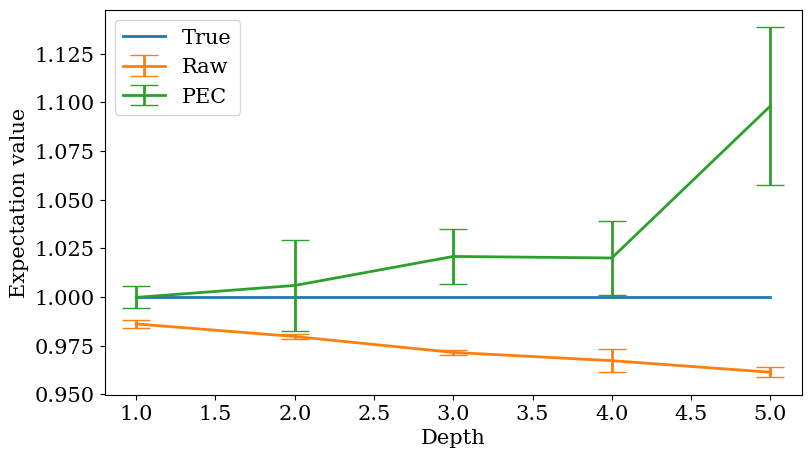

In [331]:
plt.figure(figsize=(9, 5))
plot_depths = depths[:len(avg_true_values)]
kwargs = {"capsize": 10, "lw": 2}

plt.plot(plot_depths, avg_true_values, label="True", lw=2)
plt.errorbar(plot_depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", **kwargs)
plt.errorbar(plot_depths, avg_pec_values, yerr=std_pec_values, label="PEC", **kwargs)


plt.xlabel("Depth")
plt.ylabel("Expectation value")
plt.legend()